## Exploring Health Insurance Charges:  Machine Learning

Through this notebook, we explore health insurance cost predictions by using machine learning. Several factors significantly affect insurance charges such as, age, BMI, smoking habits and existing medical conditions.

The overview of the process we will focus on is:

-**First**,we explore the relationship between various factors and health insurance charges by using EDA and data visualization, which was covered in the previous notebook.

-**Second**,we need to clean and prepare the dataset for machine learning by handling missing values, encoding categorical variables, and addressing outliers.

-**Third**,we will develop the predictive models using machine learning algorithms to estimate insurance charges and evaluate model performance.

-**Four**,we will interpret the results to identify key factors influencing insurance costs and estimate the return on investment (ROI) for insurers by predicting cost savings for high-risk customers.

In summary, this notebook covers data analysis, cleaning, model building, and evaluation to better predict and understand health insurance charges. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

In [2]:
#Load the dataset
data = pd.read_csv('insurance.csv')

#the function to add the 'existing_medical_condition' column with or without the condition
def add_existing_medical_condition(data, condition=True):
    np.random.seed(42)
    
    # Add the column based on the condition
    if condition:
        data['existing_medical_condition'] = np.where(
            (data['age'] > 50) | (data['bmi'] > 30),
            np.random.choice(['yes', 'no'], size=len(data), p=[0.3, 0.7]),
            np.random.choice(['yes', 'no'], size=len(data), p=[0.05, 0.95])
        )
    else:
        data['existing_medical_condition'] = np.random.choice(['yes', 'no'], size=len(data), p=[0.1, 0.9])
    
    return data

# Apply the function with or without the condition
data = add_existing_medical_condition(data, condition=True)

#Check for duplicate rows and remove them
def remove_duplicates(data):
    duplicates = data.duplicated().sum()
    if duplicates > 0:
        print(f"Duplicate rows found: {duplicates}")
        data.drop_duplicates(inplace=True)
    return data

def handle_outliers_iqr(df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df


def define_high_risk_customers(data):
   
    return data[(data['smoker'] == 'yes') & (data['bmi'] > 30) & (data['existing_medical_condition'] == 'yes')].copy()


# the pipeline creation function
def create_pipeline_with_outlier_handling(best_params=None):
    categorical_cols = ['sex', 'smoker', 'region', 'existing_medical_condition']
    numerical_cols = ['age', 'bmi', 'children']

    # Create the preprocessing steps
    column_transformer = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='mean'), numerical_cols),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
        ]
    )

    if best_params:
        model = RandomForestRegressor(**best_params, random_state=42)
    else:
        model = RandomForestRegressor(random_state=42)

    pipeline = Pipeline(steps=[
        ('preprocessor', column_transformer),
        ('model', model)
    ])

    return pipeline




In [3]:
# Convert categorical variables into numerical representations
categorical_features = ['sex', 'smoker', 'region', 'existing_medical_condition']
numerical_features = ['age', 'bmi','children']
target = 'charges'
 
encoded_data = pd.get_dummies(data, columns=categorical_features, drop_first=True)
    
#spilt the dataset
X = encoded_data.drop('charges', axis=1)
y = encoded_data['charges']

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

#scale the model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Building The Model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

#Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

#Model Evaluation
def evaluate_model(y_test, y_pred, model_name):
    print(f"Model: {model_name}")
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}\n")
    
evaluate_model(y_test, y_pred_lr, 'Linear Regression')
evaluate_model(y_test, y_pred_rf, 'Random Forest')


Model: Linear Regression
R^2: 0.7822780944392738
MSE: 33801049.65627446
MAE: 4198.237942525361

Model: Random Forest
R^2: 0.8671025972323702
MSE: 20632153.19822585
MAE: 2566.0997618643355



In [4]:
#Scenario 1: using the data with the exisitng medical condition and with age > 50 or BMI > 30
data_with_condition = add_existing_medical_condition(data.copy(), condition=True)

data_with_condition = remove_duplicates(data_with_condition)

high_risk_customers = define_high_risk_customers(data_with_condition)

# Handle outliers for 'age', 'bmi', and 'charges'
columns_with_outliers = ['age', 'bmi', 'charges']
for col in columns_with_outliers:
    high_risk_customers = handle_outliers_iqr(high_risk_customers, col)

print(f"High-risk customers after handling outliers: \n{high_risk_customers.describe()}")

# Prepare the features and target variable
X = data_with_condition.drop(columns=['charges'])
y = data_with_condition['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_params = {
    'n_estimators': 300,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': 10,
    'bootstrap': False
}

#create the pipeline
pipeline = create_pipeline_with_outlier_handling(best_params)
pipeline.fit(X_train, y_train)

# predict high-risk customers 
high_risk_customers['predicted_charges'] = pipeline.predict(high_risk_customers.drop(columns=['charges']))

y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# calculate savings and ROI
cost_difference = high_risk_customers['charges'] - high_risk_customers['predicted_charges']
total_savings = cost_difference.sum()
avg_savings_per_customer = cost_difference.mean()

print(f"Total Potential Savings for High-Risk Customers: ${total_savings:.2f}")
print(f"Average Savings Per High-risk Customer: ${avg_savings_per_customer:.2f}")

# ROI: savings and initial charges
total_charges = high_risk_customers['charges'].sum()
roi = (total_savings / total_charges) * 100
print(f"Estimated ROI for the insurance company: {roi:.2f}%")


Duplicate rows found: 1
High-risk customers after handling outliers: 
             age        bmi   children       charges
count  44.000000  44.000000  44.000000     44.000000
mean   37.590909  35.317940   1.000000  40596.386209
std    13.152625   3.801203   1.120631   4363.197222
min    18.000000  30.210000   0.000000  33732.686700
25%    27.000000  31.896250   0.000000  37912.222675
50%    37.500000  35.145000   1.000000  39937.518275
75%    45.250000  37.227500   2.000000  43211.687950
max    63.000000  45.224375   4.000000  51160.885862
Mean Absolute Error: 2770.01
Root Mean Squared Error: 4663.40
R² Score: 0.88
Total Potential Savings for High-Risk Customers: $46079.44
Average Savings Per High-risk Customer: $1047.26
Estimated ROI for the insurance company: 2.58%


In [5]:
# Scenario 2: using the data without the condition i.e random assignment of medical condition

data_without_condition = add_existing_medical_condition(data.copy(), condition=False)

data_without_condition = remove_duplicates(data_without_condition)

high_risk_customers = define_high_risk_customers(data_without_condition)

# Handle outliers for 'age', 'bmi', and 'charges'
columns_with_outliers = ['age', 'bmi', 'charges']
for col in columns_with_outliers:
    high_risk_customers = handle_outliers_iqr(high_risk_customers, col)

print(f"High-risk customers after handling outliers: \n{high_risk_customers.describe()}")

X = data_without_condition.drop(columns=['charges'])
y = data_without_condition['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline 
pipeline = create_pipeline_with_outlier_handling(best_params)
pipeline.fit(X_train, y_train)

# Predict on high-risk customers 
high_risk_customers['predicted_charges'] = pipeline.predict(high_risk_customers.drop(columns=['charges']))

# Predict on test data for model evaluation
y_pred = pipeline.predict(X_test)

# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Calculate savings and ROI after outlier handling
cost_difference = high_risk_customers['charges'] - high_risk_customers['predicted_charges']
total_savings = cost_difference.sum()
avg_savings_per_customer = cost_difference.mean()

print(f"Total Potential Savings for High-Risk Customers: ${total_savings:.2f}")
print(f"Average Savings Per High-risk Customer: ${avg_savings_per_customer:.2f}")

# ROI: savings and initial charges
total_charges = high_risk_customers['charges'].sum()
roi = (total_savings / total_charges) * 100
print(f"Estimated ROI for the insurance company: {roi:.2f}%")


Duplicate rows found: 1
High-risk customers after handling outliers: 
             age        bmi   children       charges
count  13.000000  13.000000  13.000000     13.000000
mean   38.538462  36.022692   0.692308  41701.616735
std    14.694757   5.687067   1.031553   5454.763720
min    19.000000  30.360000   0.000000  33750.291800
25%    24.000000  31.920000   0.000000  38344.566000
50%    40.000000  35.090000   0.000000  39727.614000
75%    48.000000  39.400000   1.000000  44501.398200
max    63.000000  50.620000   3.000000  53736.646500
Mean Absolute Error: 2757.87
Root Mean Squared Error: 4663.04
R² Score: 0.88
Total Potential Savings for High-Risk Customers: $16387.11
Average Savings Per High-risk Customer: $1260.55
Estimated ROI for the insurance company: 3.02%


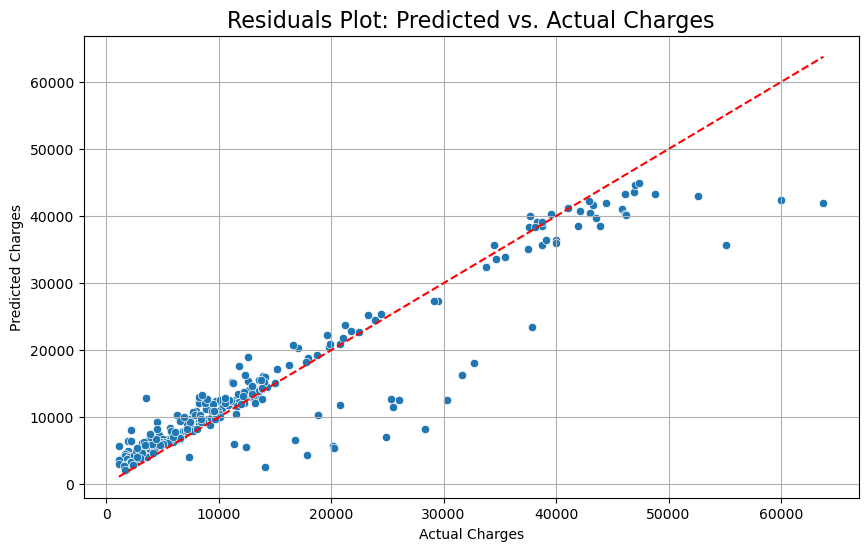

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Residuals Plot: Predicted vs. Actual Charges', fontsize=16)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.grid(True)
plt.show()

This residual plot compares predicted versus actual charges for the regression model. The red dashed line shows the ideal scenario where predictions match the actual values perfectly. Most points are close to this line, indicating accurate predictions for most cases. However, at higher charge values, the model tends to underpredict, as shown by points deviating from the line. Predictions for lower charges are more accurate, with the points more densely clustered along the line.

## Conclusion

In comparing both scenarios, we find that the MAE and RSME metrics are very similar, with Scenario 2 showing a slightly lower for MAE and RSME. Additionally, both scenarios have an R^2 score of 0.88, indicating that the model explains about 88% of the variance in the data, demonstrating a good fit overall.

Scenario 1 results have a significantly higher total savings, by identifying 44 high-risk customers compared to only 13 in Scenario 2. While Scenario 1 demonstrates greater total savings, Scenario 2 offers a better average savings per high-risk customer, this implies that although Scenario 2 has fewer high-risk customers, the savings potential for each customer is higher.


For evaluating the Return on Investment (ROI), Scenario 2 has a higher ROI of 3.02% compared to Scenario 1 of 2.58%. This improved ROI is driven by the higher average savings per customer in Scenario 2, even though the total savings are lower.

In summary, Scenario 1 is advantageous for maximizing total savings, as it identifies and provides savings for more high-risk customers. Conversely, Scenario 2 is more effective for achieving higher average savings per customer and having a better ROI, despite identifying fewer customers of high-risk.

Lastly,for the residual plot, the model performs well for mid-range charges but underpredicts higher charges, although the overall fit remains strong which reflects a linear relationship between actual and predicted values.

In conclusion, the current model demonstrates a good fit, but there are opportunities for more improvement. We can explore model tuning through hyperparameter optimization to further improve performance, particularly for higher charge predictions. Additionally, adding new features or transforming existing ones may enhance the model's accuracy and better capture the underlying relationships in the data.